# Cell-cell communication

*TL;DR This chapter serves as a brief overview of basic concepts and assumptions of cell-cell communication inference from single-cell transcriptomics data. We provide examples of the two most common approaches for CCC inference: those that focus on ligand-receptor interactions and those that include downstream response.*

## Motivation

Cell communication is the process of cells to react to stimuli from their environment and also from themselves. In mutlicellular organisms, the dynamic coordination of cells, also called cell-cell communication (CCC), is involved in many biological processes, such as apoptosis and cell migration, and is consequently essential in homeostasis and disease. CCC commonly focuses on protein-mediated interactions, most typically perceived as a secreted ligand binding to its corresponding plasma membrane receptor. However, this picture can be broadened to include secreted enzymes, extra-cellular matrix proteins, transporters, and interactions that require the physical contact between cells, such as cell-cell adhesion proteins and gap junctions {cite}`armingol_2021`. Cell communication is further not independent of other processes, but the contrary, as external stimuli commonly elicit a downstream response. In the case of CCC, this is typically perceived as the induction of canonical pathways and downstream transcription factors in the cells receiving the signal, or receiver cells. Ultimately these external stimuli alter the function of receiver cells, and this alteration is further propagated via the subsequent interaction of these cells with their microenvironment. 
Traditionally, the study of CCC required specialized in-situ biochemical assays, such proximity labelling proteomics, co-immunoprecipitation, and yeast two-hybrid screening {cite}`armingol_2021`. Yet, the rapid developments and dropping costs of transcriptomics data generation has enabled a paradigm shift away from focusing on which types of cells are present, but rather on the relationships between them {cite}`almet_2021`. As a consequence, CCC inference from single-cell data is now becoming a routine approach, capable of providing a system-level hypotheses of intercellular crosstalk in vivo.

## Approaches

As a result of this increased interest, a number of computational tools for CCC inference from single-cell transcriptomics have emerged that can be classified as those that predict CCC interactions alone, commonly referred to as ligand-receptor inference methods (e.g. {cite}`efremova_2020,jin_2021,raredon_2022,hou2020predicting`), and those that additionally estimate intracellular activities induced by CCC (e.g. {cite}`wang_2019,browaeys_2020,hu_2021`). Both categories of tools use gene expression information as a proxy of protein abundance, and typically require the clustering of cells into biologically-meaningful groups (See Annotation tutorial). These CCC tools infer intercellular crosstalk between pairs of cell groups, one group being the source and the other the receiver of a CCC event. CCC events are thus commonly represented as interactions between proteins, expressed by the source and receiver cell clusters.

The information about the interacting proteins is commonly extracted from prior knowledge resources. In the case of ligand-receptor methods, the interactions can also be represented by heteromeric protein complexes, as different subunit combinations can induce distinct responses and the inclusion of protein complex information has been shown to reduce false positive rates {cite}`efremova_2020,jin_2021,liu_2022`. On the other hand, the approaches that model intracellular signalling also leverage the functional information in receiver cell types, and thus require additional information such as intracellular protein-protein interaction network and/or gene regulatory interactions.

Recent work has highlighted that the choice of method and/or resource leads to limited consensus in inferred predictions when using different tools {cite}`dimitrov_2022,wang_2022,liu_2022`, thus prompting caution when interpreting their output. The CCC field is further plagued by the lack of ground truth {cite}`armingol_2021,almet_2021`, capable of capturing the complex and dynamic interplay between large numbers of cells and molecules. Nevertheless, independent evaluations have shown that CCC methods are fairly robust to the introduction of noise {cite}`dimitrov_2022,wang_2022,liu_2022`, and are largely concordant with alternative data modalities such as intracellular signalling and spatial information {cite}`dimitrov_2022,liu_2022`.

In this chapter, we first provide an introduction and example to perhaps the most common and simplest CCC approaches, i.e. ligand-receptor inference with CellPhoneDB {cite}`efremova_2020` and LIANA {cite}`dimitrov_2022`. Then we showcase NicheNet as an example of CCC inference that takes intercellular activities into account {cite}`browaeys_2020`. Finally, we highlight the common assumptions and limitations of CCC inference from single-cell transcriptomics data as well as suggestions how to improve confidence in intercellular communication predictions. Note that here we generalize for the sake of simplicity, however, there are a plethora of different and newly emerging CCC approaches. We highlight some of those in the **Outlook** section.

<img src="../_static/images/mechanisms/cell_cell_communication.svg" alt="CCC Overview" class="bg-primary mb-1" width="800px">

**FIGURE 22.1**. To be adapted to fit the book style and not specifici to LIANA and NicheNet

## Environment setup

In [1]:
# python libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import liana as li
import decoupler as dc

import session_info

In [2]:
# Setting up R dependencies
import anndata2ri
import rpy2
from rpy2.robjects import r
import random

anndata2ri.activate()

%load_ext rpy2.ipython

In [39]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(SingleCellExperiment)
    library(tidyverse)
})

In [4]:
# figure settings
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200, facecolor="white")
sc.set_figure_params(figsize=(5, 5))

## Case Study

As a simple example, we will look at ~25k PBMCs from 8 lupus patients, each before and after IFN-β stimulation {cite}`kang2018multiplexed`. Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

So, let's first download the pre-processed data.

In [5]:
# Read in
adata = sc.read(
    "kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122"
)
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In this case study, we will assume that cell types such as B cells and CD4 T cells carry out a signal mediator role, while others, such as CD8 T cells and Natural Killer cells, are composed of the cells that carry out the response. In other words, we will treat B and CD4 T cells as the sources of CCC signalling, while the latter are the receivers of CCC stimuli. This is of course an oversimplification as signalling sources and receivers are expected to be dynamic and multi-directional, thus the cell types that we treat as which category depends on the hypothesis in mind.

In [6]:
adata.obs["cell_type"].cat.categories

Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'CD8 T cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')

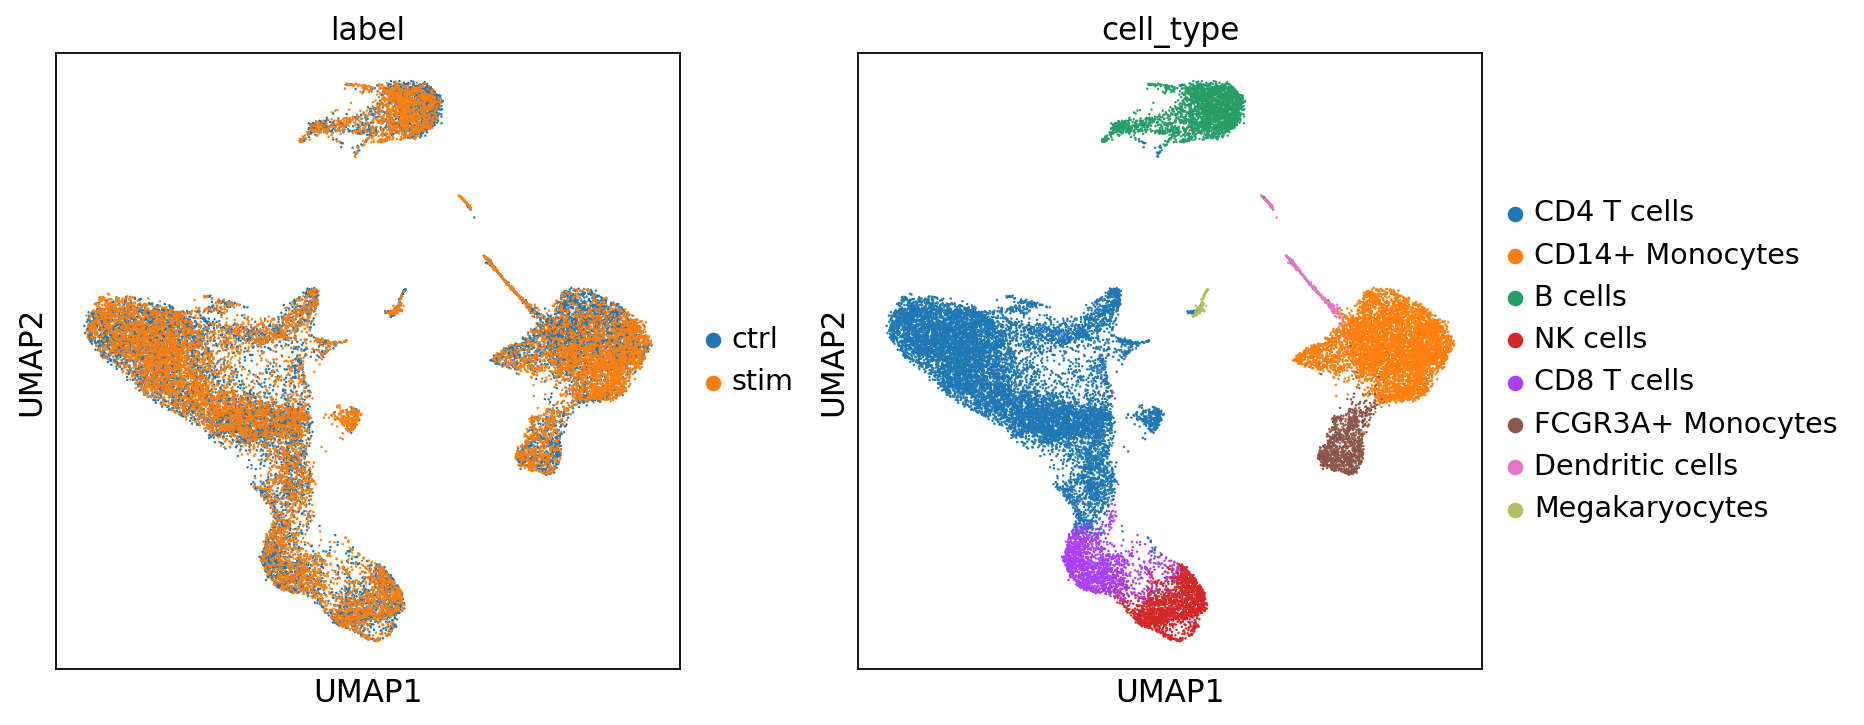

In [7]:
sc.pl.umap(adata, color=["label", "cell_type"])

Apply basic quality control steps to remove any low quality cells and lowly expressed genes. We refer the user to the [Quality Control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) chapter for more extensive QC steps.

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
# Store the counts for later use
adata.layers["counts"] = adata.X.copy()
# Rename label to condition, replicate to patient
adata.obs = adata.obs.rename({"label": "condition", "replicate": "patient"}, axis=1)
# assign sample
adata.obs["sample"] = (
    adata.obs["condition"].astype("str") + "&" + adata.obs["patient"].astype("str")
)

We will also normalize the data to ensure that the count depth is equalized for all cells, given that we need the gene expression values to be comparable across the cell types. We refer the user to the [Normalization](https://www.sc-best-practices.org/preprocessing_visualization/normalization.html#) chapter for more information and alternative normalization approaches that might fit their data better.

In [10]:
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

### Ligand-receptor inference

First, we will run the CellPhoneDB (v2) ligand-receptor method {cite}`efremova_2020`.

We will run CellPhoneDB on the data post IFN-beta stimulation alone, as such methods were initially designed for the inference of CCC events in "steady-state" data, or in other words, they are meant to be used not across samples or conditions, but rather on a single condition or sample at a time. Note that, nevertheless, certain approaches exist to apply ligand-receptor methods across conditions but these are out of scope for this tutorial, and instead we refer to them in the **Outlook** section.

In [11]:
adata_stim = adata[adata.obs["condition"] == "stim"].copy()
adata_stim

AnnData object with n_obs × n_vars = 12301 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'label_colors', 'cell_type_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [12]:
# import cellphonedb via liana
from liana.method import cellphonedb

CellPhoneDB is one of the most commonly-used CCC tools, it represents intercellular communication events as the average gene expression of the proteins involved in the interaction. The proteins involved can also be can also take the form of heteromeric complexes, and in that case the minimum gene expression of the subunits is considered. In addition to the expression average, interaction significance is determined against a null distribution, generated by shuffling the cell group labels.

Note that we are grouping by cell type and that the CCC statistics that we get will reflect the cell types that were previously pre-defined.

In [13]:
cellphonedb(
    adata_stim, groupby="cell_type", use_raw=False, return_all_lrs=True, verbose=True
)

Using `.X`!
Converting mat to CSR format
227 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/liana4.1/lib/python3.7/site-packages/pandas/core/indexing.py:1667: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.46 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 12301 samples and 15474 features


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.19it/s]


By default, the results are written in place within the anndata object, more specifically in `.uns['liana_res']`.

Let's examine the output from the CellPhoneDB method:

In [14]:
adata_stim.uns["liana_res"].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lrs_to_keep,lr_means,cellphone_pvals
0,LGALS9,LGALS9,0.072739,0.101973,PTPRC,PTPRC,0.457824,0.501761,CD4 T cells,CD4 T cells,True,0.265281,1.0
9,LGALS9,LGALS9,0.072739,0.101973,CD44,CD44,0.304042,0.364741,CD4 T cells,CD4 T cells,True,0.188391,1.0
38,VIM,VIM,0.507059,0.519725,CD44,CD44,0.304042,0.364741,CD4 T cells,CD4 T cells,True,0.405550,1.0
39,PKM,PKM,0.230863,0.278267,CD44,CD44,0.304042,0.364741,CD4 T cells,CD4 T cells,True,0.267453,1.0
67,LGALS9,LGALS9,0.072739,0.101973,CD47,CD47,0.213795,0.272807,CD4 T cells,CD4 T cells,True,0.143267,1.0


Here, we see that stats are provided for both ligand and receptor entities, more specifically: - `ligand` and `receptor` are typically the two entities that interact. As a reminder, CCC events are not limited to secreted signalling, but we refer to them as `ligand` and `receptor` for simplicity. 

Also, in the case of heteromeric complexes, the `ligand` and `receptor` columns represent the subunit with minimum expression, while *_complex corresponds to the actual complex, with subunits being separated by `_`.

- `source` and `target` columns represent the source/sender and target/receiver cell identity for each interaction, respectively

- `*_props`: represents the proportion of cells that express the entity. 

  By default, in CellPhoneDB and LIANA, any interactions in which either entity is not expressed in above 10% of cells per cell type is considered as a false positive,
  under the assumption that since CCC occurs between cell types, a sufficient proportion of cells within should express the genes.

- `*_means`: entity expression mean per cell type

- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor interaction **magnitude**

- `cellphone_pvals`: permutation-based p-values, as a measure of interaction **specificity**

Note that `ligand`, `receptor`, `source`, and `target` columns are returned by every ligand-receptor method, while the rest of the columns can vary across the ligand-receptor methods, as each method infers relies on different assumptions and scoring functions, and hence each returns different ligand-receptor scores.
Nevertheless, typically most methods use a pair of scoring functions - where one often corresponds to the **magnitude** (strength) of interaction and the other reflects how **specificity** of a given interaction to a pair cell identities.

### Visual exploration

We can now visualize the results that we just obtained as a dotplot, in which rows represent the prioritized interactions between source/sender (top) and target/receiver (bottom) cell types.

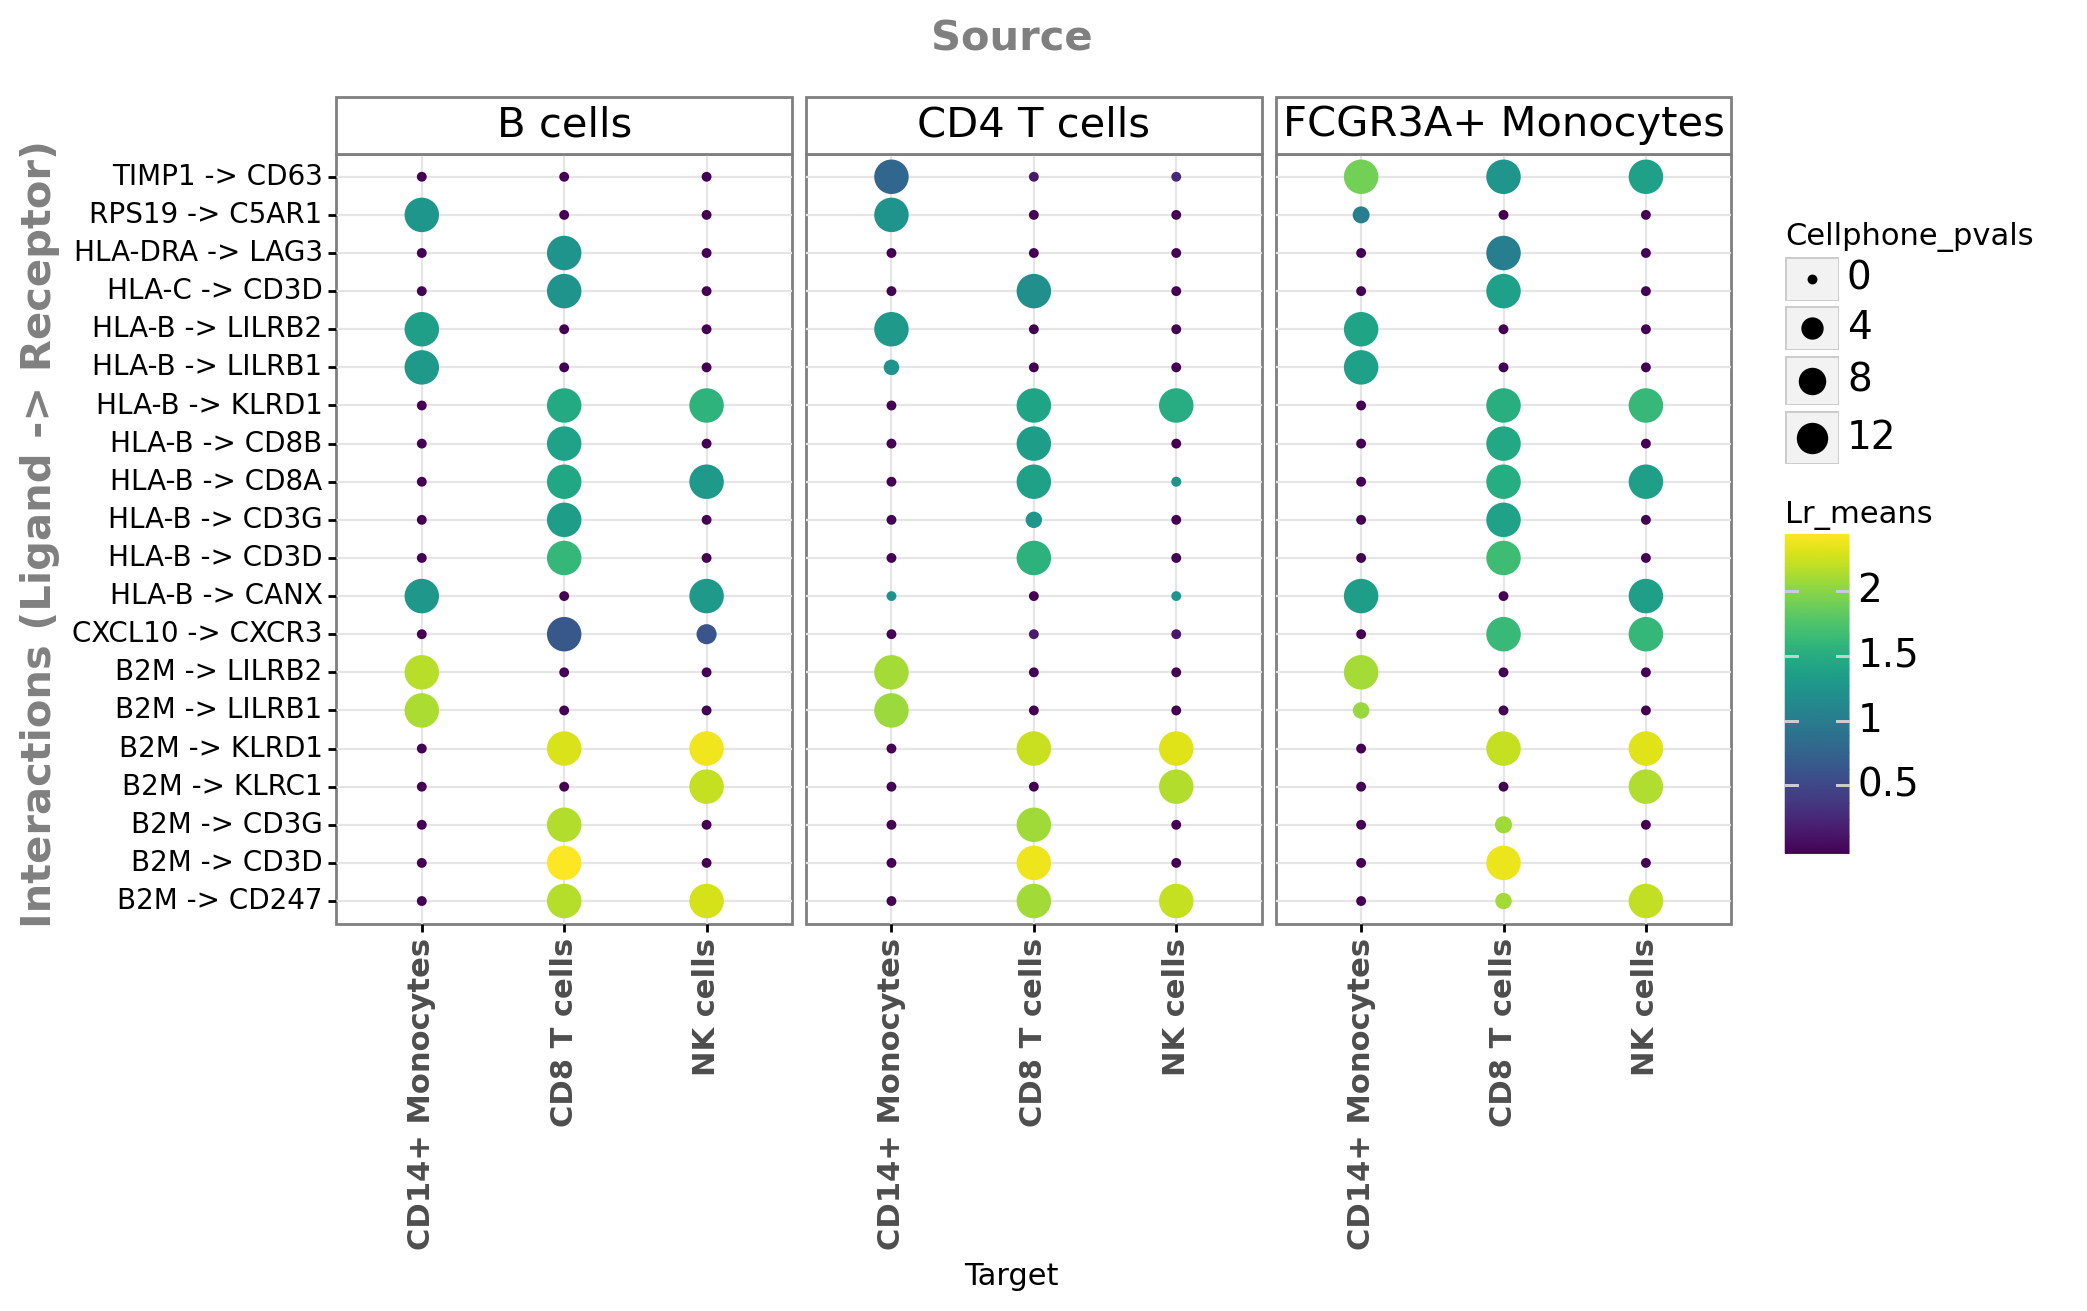

<ggplot: (8789873643605)>

In [15]:
li.pl.dotplot(
    adata=adata_stim,
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=["CD4 T cells", "B cells", "FCGR3A+ Monocytes"],
    target_labels=["CD8 T cells", "CD14+ Monocytes", "NK cells"],
    # since cpdbv2 suggests using a filter to FPs
    # we can filter the interactions according to p-values <= 0.01
    filterby="cellphone_pvals",
    filter_lambda=lambda x: x <= 0.01,
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    orderby="lr_means",
    orderby_ascending=False,  # we want to prioritize those with highest expression
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

Great, we get a number of interactions potentially linked to IFN-beta stimulation. 

We can also see that both the magnitude (expression strength) and specificity of the interactions are cell-type dependent.
For example, the potential binding of HLA-B binding to CD8A/B logically occurs only when the receiver cells are CD8 T cells.

### Generating a Ligand-Receptor consensus with LIANA

Given the reported limited agreement between the interactions inferred by different ligand-receptor methods, as a way to further confidence in a potential interaction of interest, one could check if this interaction is predicted as relevant by more than a single method. In the same manner, one could also use multiple methods and focus their consensus, or in other words focus on interactions consistently predicted as relevant. To this end, we will run the `rank_aggregate` method of liana {cite}`dimitrov_2022`, which generates a probability distribution of highly ranked interactions across the methods.

Let's first examine the ligand-receptor methods in LIANA:

In [16]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,pvals,CellPhoneDBv2's permutation approach applied t...


Let's now run the Rank_Aggregate method, which will essentially run the other methods in the background and then generate a consensus.

In [17]:
from liana.method import rank_aggregate

In [18]:
rank_aggregate(
    adata_stim, groupby="cell_type", return_all_lrs=True, use_raw=False, verbose=True
)

Using `.X`!
Converting mat to CSR format
227 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/liana4.1/lib/python3.7/site-packages/pandas/core/indexing.py:1667: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.46 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 12301 samples and 15474 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.14it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.89it/s]


Let's now check how the output of liana's rank_aggregate:

In [19]:
adata_stim.uns["liana_res"].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
1129,CD8 T cells,CD8 T cells,B2M,CD3D,2.562213,0.0,3.070147,1.070524,0.690730,0.062383,0.982125,0.123504,0.0,2.082230e-11,1.410212e-09,9.840017e-13
1094,NK cells,CD8 T cells,B2M,CD3D,2.526163,0.0,3.020199,0.968021,0.633204,0.061368,0.981981,0.121578,0.0,2.082230e-11,1.410212e-09,3.320956e-12
831,CD8 T cells,NK cells,B2M,KLRD1,2.511733,0.0,2.622731,1.541763,0.858930,0.080626,0.980689,0.110393,0.0,2.082230e-11,1.410212e-09,8.965786e-11
806,NK cells,NK cells,B2M,KLRD1,2.475684,0.0,2.580062,1.439260,0.801404,0.079314,0.980533,0.108647,0.0,2.082230e-11,1.410212e-09,1.574812e-10
1052,B cells,CD8 T cells,B2M,CD3D,2.378116,0.0,2.815072,0.547071,0.403862,0.057200,0.981348,0.114293,0.0,2.475325e-11,1.628812e-09,2.044504e-10


Here, we can see the output of the scoring functions of all methods (refer to the table above, if interested to map which score belong to which method). More importantly, we also get the `magnitude_rank` and `specificity_rank` for each interaction, which represent the consensus interaction **magnitude** (strength of expression) and **specificity** (across all cell type pairs), respectively. For example, going back to CellPhoneDB, `lr_mean` and `cellphone_pvals` will be correspondingly aggregated in those.

Let's generate the same plot, but now using the aggregate of the methods:

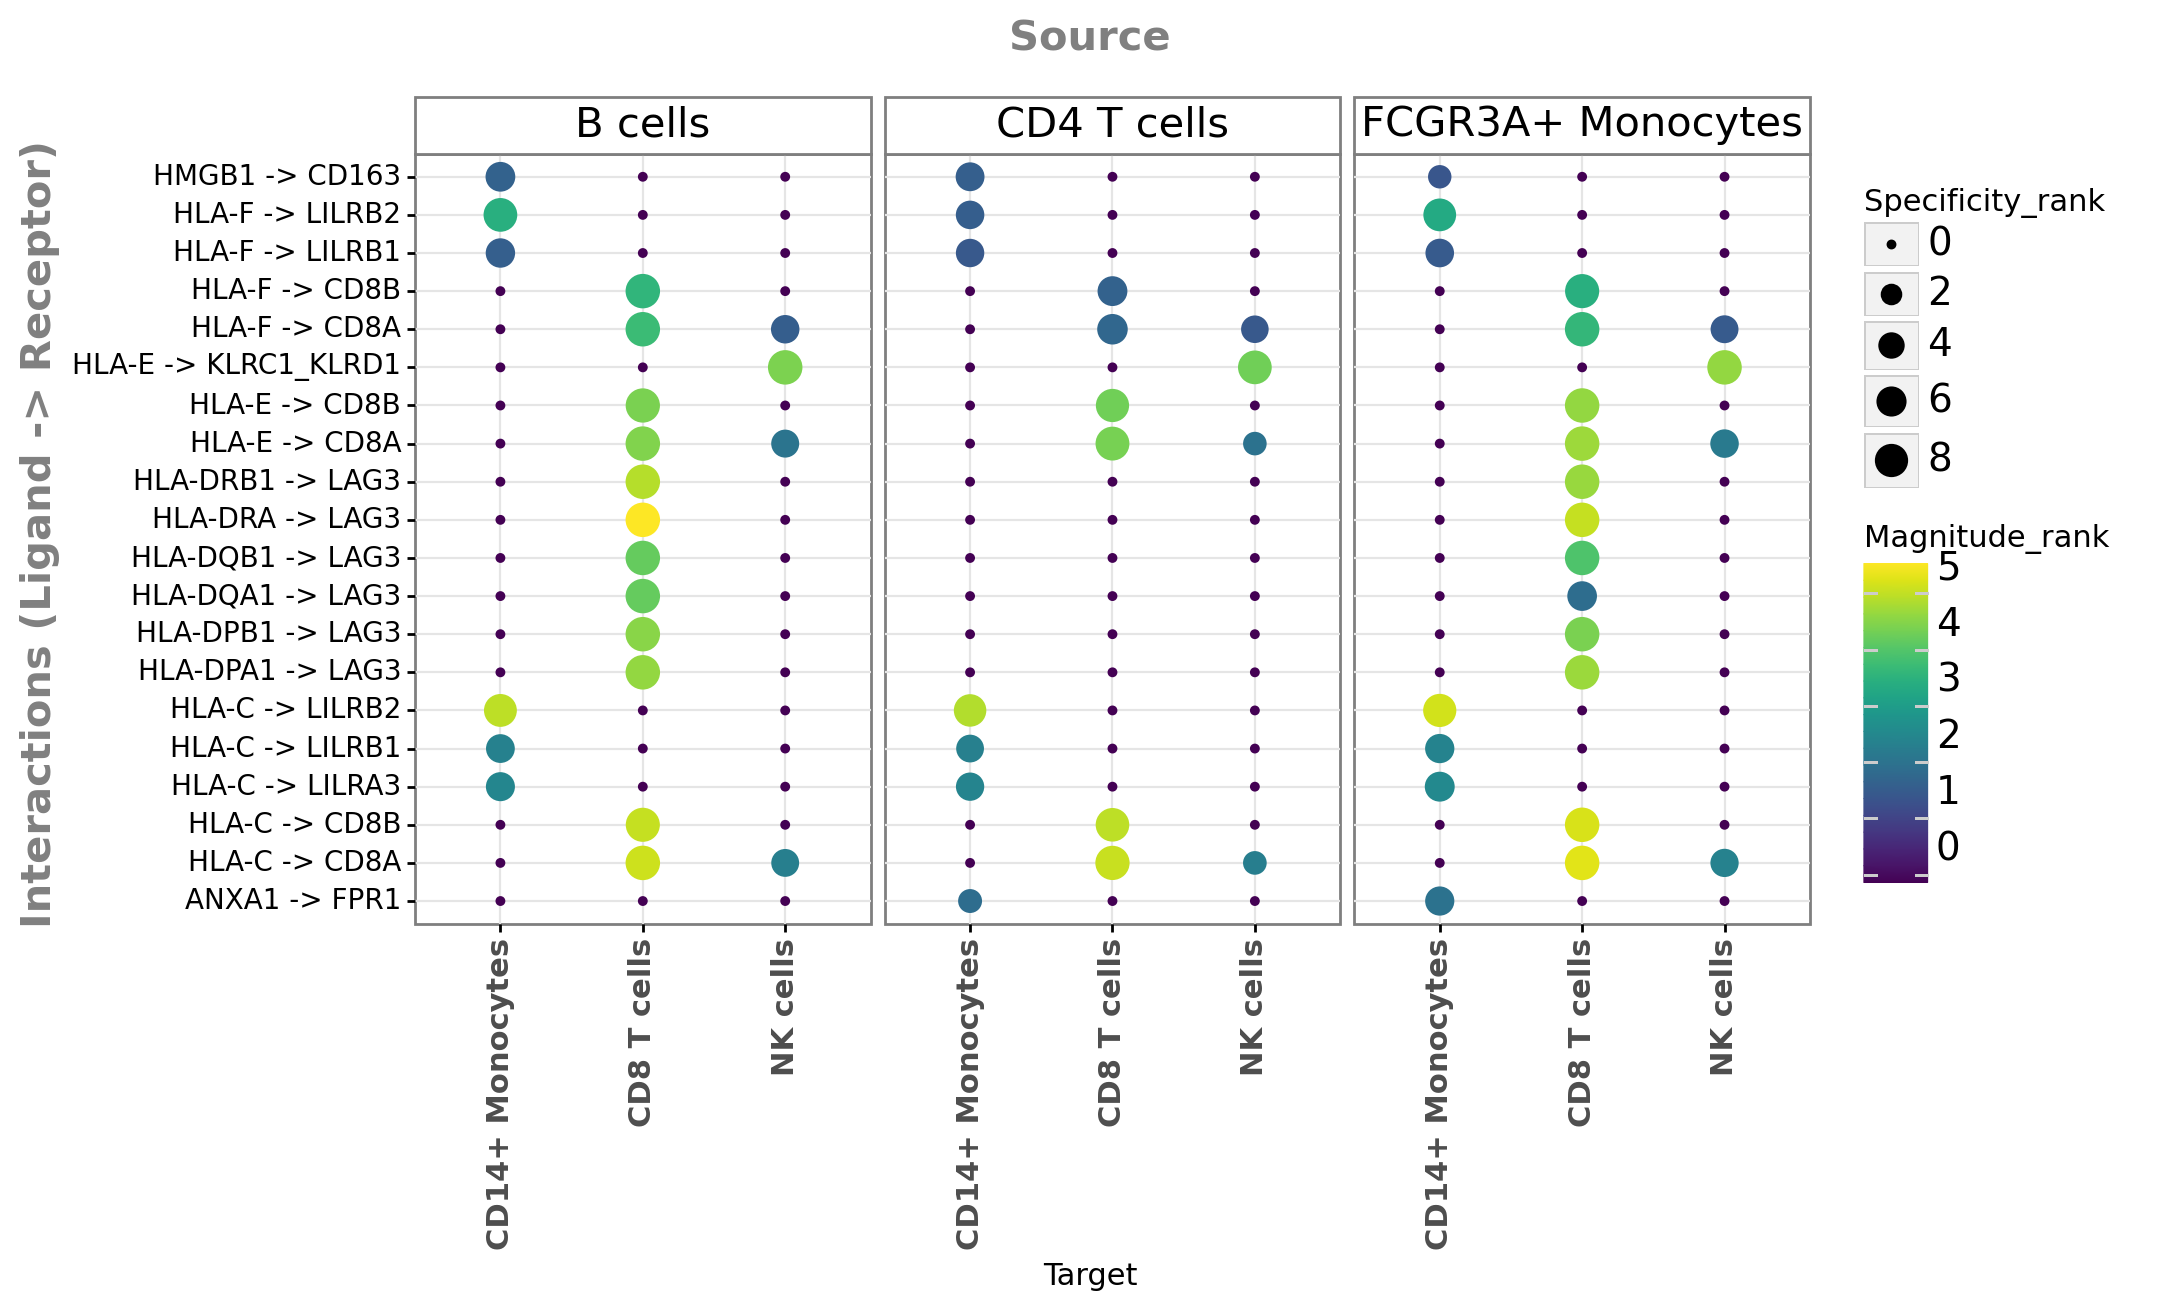

<ggplot: (8789873547585)>

In [20]:
li.pl.dotplot(
    adata=adata_stim,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # We choose only the cell types which we wish to plot
    source_labels=["CD4 T cells", "B cells", "FCGR3A+ Monocytes"],
    target_labels=["CD8 T cells", "CD14+ Monocytes", "NK cells"],
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

Although, the prioritized interactions by both CellPhoneDB and LIANA seem biologically-plausible and potentially relevant to the treatment, it is challenging to ascertain their relevance. In particular, because the advantage of these methods to generate hypothesis-free systems-level hypotheses happens to also be one of their major disadvantage, as we end up with huge lists of interactions, and choosing targets for subsequent experimental validation can be challenging.

Thus, prior to experimental validation, we suggest that any potential interaction hypotheses should be supported with additional prior knowledge. This may include domain knowledge for the specific condition (e.g. cell types or receptors of interest), as well as orthogonal modalities, such as protein abundance, spatial co-localization, or downstream signalling. To this end, we also further refer the reader to the [enrichment analysis](https://www.sc-best-practices.org/conditions/gsea_pathway.html) and [spatial CCC](TODO) chapters.

## Modelling intercellular signalling with NicheNet

NicheNet is another type of CCC method that considers the **intra**cellular signaling effects triggered by **inter**cellular interactions {cite}`browaeys_2020`. 

In short, NicheNet infers associations between ligands and the downstream targets that they potentially modulate {cite}`browaeys_2020`. Or in other words, NicheNet assumes that a certain sender/source cell type produces a ligand, and the binding of that ligand to a specific receiver/target cell type(s) leads to a signal propagation that affects master gene regulators, or transcription factors, and subsequently their targets.

To achieve that, NicheNet integrates three layers of prior knowledge, covering ligand-receptor, intracellular signaling, and gene regulatory mechanisms. Using these three layers of information, NicheNet first employs a network algorithm, known as Personalized PageRank, to estimate the probability of a random walk from a ligand to terminate at a given regulator, or it estimates the signalling probability of a given ligand modulating a particular regulator. This signalling probability is then multiplied with a weight matrix of regulators to target genes in order to obtain **ligand-target** regulatory potential scores. 

For a more detailed description of the NicheNet method, we specifically refer the reader to the [footprint part of the enrichment analysis chapter](https://www.sc-best-practices.org/conditions/gsea_pathway.html) as well as NicheNet's [tutorials](https://github.com/saeyslab/nichenetr) and manuscript {cite}`browaeys_2020`.

### Load NicheNet Prior-Knowledge

As mentioned above, NicheNet requires three layers of information, namely:
- a ligand_target_matrix - denotes the potential that a ligand might regulate the expression of a target genes. The weights in this matrix are based on prior knowledge and are required to prioritize possible ligand-receptor interactions and affected target genes.

- lr_network - the database of ligand-receptor interactions needed to define expressed ligands, receptors and their interactions.

- weighted_networks - contains integrated ligand-receptor, signaling and gene-regulatory interactions.

We will load each of those from Zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7074291.svg)](https://doi.org/10.5281/zenodo.7074291) (this might take a couple of minutes).

In [21]:
%%R
# load NicheNet (NicheNet is only available on GitHub)
suppressPackageStartupMessages({
    if(!require(nichenetr)) remotes::install_github("saeyslab/nichenetr")
})

# Increase timeout threshold
options(timeout=600)

# Load PK
ligand_target_matrix <- readRDS(url("https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final.rds"))
lr_network <- readRDS(url("https://zenodo.org/record/7074291/files/lr_network_human_21122021.rds"))
weighted_networks <- readRDS(url("https://zenodo.org/record/7074291/files/weighted_networks_nsga2r_final.rds"))

#### Step 1. Define cell types of interest to be considered as senders/sources and receiver/targets of CCC interactions

In [22]:
sender_celltypes = ["CD4 T cells"]
receiver_celltypes = ["CD8 T cells", "CD14+ Monocytes", "NK cells"]

#### Step 2. Define a set of ligands that can **potentially** affect receiver cell types

Similarly to the ligand-receptor methods above, here we are only interested in the potential interactions that involve sufficiently expressed genes in each cell type. So, we will assume that e.g. 10% of the cells is a good threshold to reflect genes as expressed within a cell type.

In [23]:
# Helper function to obtain sufficiently expressed genes
from functools import reduce


def get_expressed_genes(adata, cell_type, expr_prop):
    # calculate proportions
    temp = adata[adata.obs["cell_type"] == cell_type, :]
    a = temp.X.getnnz(axis=0) / temp.X.shape[0]
    stats = (
        pd.DataFrame({"genes": temp.var_names, "props": a})
        .assign(cell_type=cell_type)
        .sort_values("genes")
    )

    # obtain expressed genes
    stats = stats[stats["props"] >= expr_prop]
    expressed_genes = stats["genes"].values

    return expressed_genes

In [24]:
sender_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata, cell_type=cell_type, expr_prop=0.1)
        for cell_type in sender_celltypes
    ],
)
receiver_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata, cell_type=cell_type, expr_prop=0.1)
        for cell_type in receiver_celltypes
    ],
)

Then use this information to keep only ligand-receptor pairs in the NicheNet network that are expressed.

In [25]:
%%R -i sender_expressed -i receiver_expressed
# get ligands and receptors in the resource
ligands <- lr_network %>% pull(from) %>% unique()
receptors <- lr_network %>% pull(to) %>% unique()

# only keep the intersect between the resource and the data
expressed_ligands <- intersect(ligands, sender_expressed)
expressed_receptors <- intersect(receptors, receiver_expressed)

# filter the network to only include ligands for which both the ligand and receptor are expressed
potential_ligands <- lr_network %>% 
  filter(from %in% expressed_ligands & to %in% expressed_receptors) %>%
  pull(from) %>% unique()

#### Step 3. Define a gene set of interest in receiver cell type(s)

These are typically genes changes in which we assume are related to alteration in cell-cell communication, i.e. these are the genes thought to be affected by ligand signalling. For example, one can assume that differentially expressed genes between conditions in receiver cell type(s) are driven by ligands from one of more interacting sender cell populations.

So, we will now use **decoupler** to generate pseudobulk profiles per cell type and sample, and then do differential expressed analysis on those. A crucial step of pseudo-bulking is filtering out genes that are not expressed across most cells and samples, since they are very noisy and can result in unstable log fold changes. To get robust profiles, genes are thus filtered out if again they are not expressed sufficiently per sample (min_prop) and and in not enough samples. We refer the reader to the [enrichment analysis]() and [differential expression]() chapters for more info on differential expression analysis and pseudobulk profiles.

In [26]:
# Get pseudo-bulk profile
padata = dc.get_pseudobulk(
    adata,
    sample_col="sample",
    groups_col="cell_type",
    use_raw=False,
    min_prop=0.1,
    min_smpls=3,
)

# Normalize
sc.pp.normalize_total(padata, target_sum=1e4)
sc.pp.log1p(padata)
# Check how this looks
padata

/home/dbdimitrov/anaconda3/envs/liana4.1/lib/python3.7/site-packages/decoupler/utils_anndata.py:268: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/dbdimitrov/anaconda3/envs/liana4.1/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


AnnData object with n_obs × n_vars = 108 × 4412
    obs: 'condition', 'cell_type', 'patient', 'sample'
    uns: 'log1p'

Then we perform a very simple differential analysis contrast. For this example we will use t-test as is implemented in `scanpy` but we could use any other.

In [27]:
logFCs, pvals = dc.get_contrast(
    padata,
    group_col="cell_type",
    condition_col="condition",
    condition="stim",
    reference="ctrl",
    method="t-test",
)

Then keep only the positive significant differentially expressed genes in the receiver cell type(s)

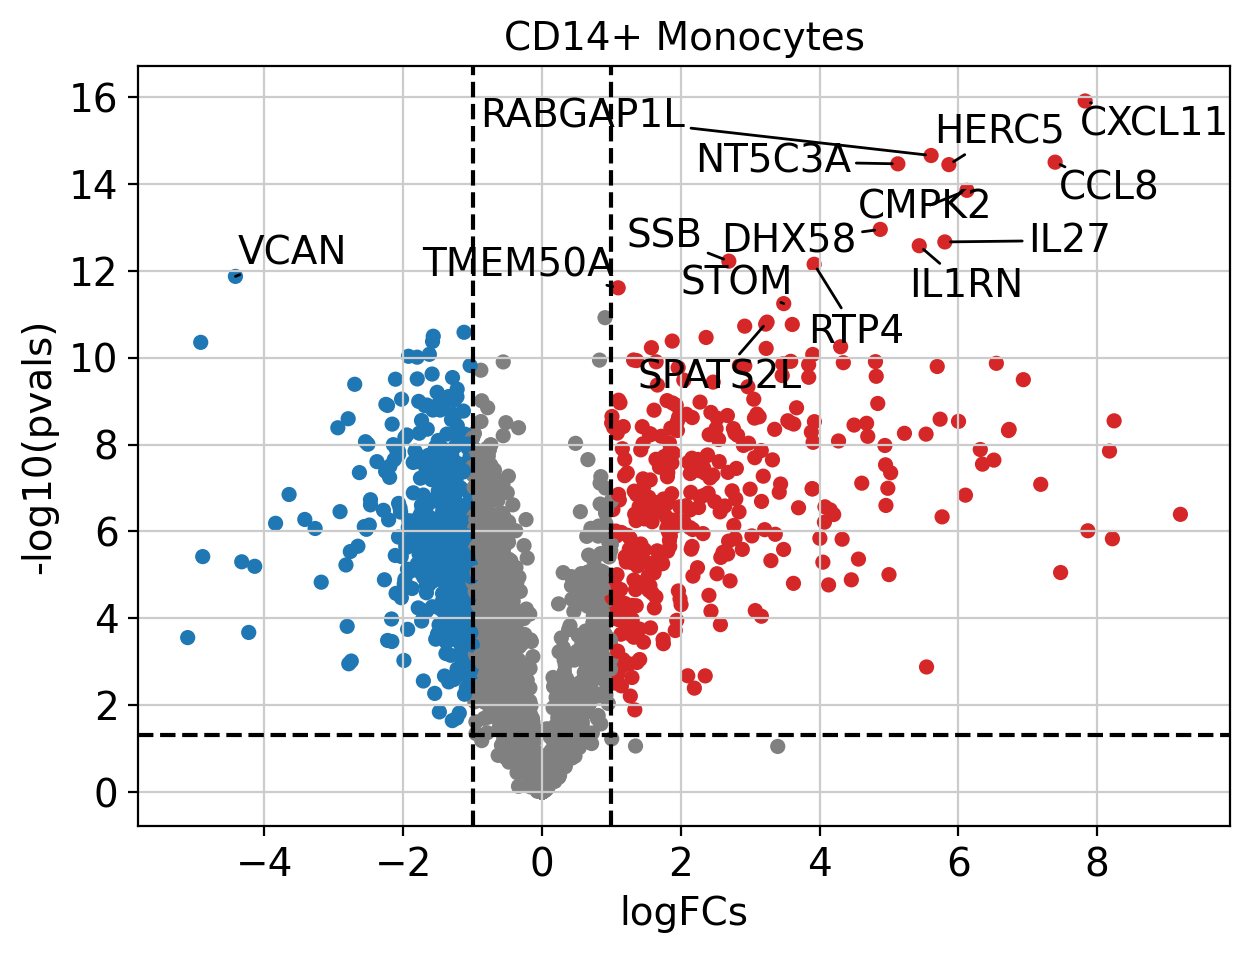

In [28]:
# Visualize those for e.g. CD14+ Monocytes
dc.plot_volcano(logFCs, pvals, "CD14+ Monocytes", top=15, sign_thr=0.05, lFCs_thr=1)

In [29]:
# format results
deg = dc.format_contrast_results(logFCs, pvals)
# only keep the receiver cell type(s)
deg = deg[np.isin(deg["contrast"], receiver_celltypes)]
deg.head()

,contrast,name,logFCs,pvals,adj_pvals
4412,CD14+ Monocytes,CXCL11,7.827358,1.228051e-16,0.0
4413,CD14+ Monocytes,RABGAP1L,5.607874,2.210409e-15,0.0
4414,CD14+ Monocytes,CCL8,7.395164,3.149772e-15,0.0
4415,CD14+ Monocytes,NT5C3A,5.129127,3.439422e-15,0.0
4416,CD14+ Monocytes,HERC5,5.864352,3.587681e-15,0.0


Now that we have the DE stats for the receiver cell type, we can use those to define the background and geneset of interest for ligand activity analysis with NicheNet.

In [30]:
# define background of sufficiently expressed genes
background_genes = deg["name"].values

# only keep significant and positive DE genes
deg = deg[(deg["pvals"] <= 0.05) & (deg["logFCs"] > 1)]
# get geneset of interest
geneset_oi = deg["name"].values

#### Step 4. NicheNet ligand activity estimation

To estimate ligand activity, NicheNet uses the regulatory potential of genes (based on prior knowledge) to predict which ligand is predicts best the gene set of interest.
Or in other words, it assesses whether the genes with high regulatory potential in regards to a specific ligand, are more likely to belong to the geneset of interest that we derive for the receiver cell type(s).
Conceptually, this is not too dissimilar from standard [enrichment analysis](), and NicheNet proposes different ways to estimate ligand activity, such as the area under the receiver operating characteristic curve, or Pearson correlation {cite}`browaeys_2020`.

In [31]:
%%R -i geneset_oi -i background_genes -o ligand_activities

ligand_activities <- predict_ligand_activities(geneset = geneset_oi, 
                                               background_expressed_genes = background_genes,
                                               ligand_target_matrix = ligand_target_matrix,
                                               potential_ligands = potential_ligands)

ligand_activities <- ligand_activities %>% 
  arrange(-aupr) %>% 
  mutate(rank = rank(desc(aupr)))

# show top10 ligand activities
head(ligand_activities, n=10)

# A tibble: 10 × 6
   test_ligand auroc   aupr aupr_corrected pearson  rank
   <chr>       <dbl>  <dbl>          <dbl>   <dbl> <dbl>
 1 PTPRC       0.727 0.147          0.0979  0.185      1
 2 HLA-F       0.700 0.125          0.0760  0.172      2
 3 HLA-A       0.703 0.114          0.0653  0.163      3
 4 CD48        0.708 0.112          0.0634  0.107      4
 5 CCL5        0.702 0.112          0.0630  0.0768     5
 6 HLA-C       0.705 0.112          0.0628  0.158      6
 7 HLA-E       0.698 0.111          0.0627  0.120      7
 8 HLA-B       0.691 0.110          0.0618  0.151      8
 9 B2M         0.683 0.0995         0.0508  0.103      9
10 HMGB1       0.665 0.0977         0.0490  0.0952    10


#### Step 5. Infer & Visualize top-predicted target genes for top ligands

In [32]:
%%R -o vis_ligand_target
top_ligands <- ligand_activities %>%
  top_n(15, aupr) %>% 
  arrange(-aupr) %>%
  pull(test_ligand) %>%
  unique()

# get regulatory potentials
ligand_target_potential <- map(top_ligands,
                               ~get_weighted_ligand_target_links(.x,
                                                                 geneset = geneset_oi,
                                                                 ligand_target_matrix = ligand_target_matrix,
                                                                 n = 500)
                              ) %>%
    bind_rows() %>% 
    drop_na()
    
# prep for visualization
active_ligand_target_links <- 
  prepare_ligand_target_visualization(ligand_target_df = ligand_target_potential, 
                                      ligand_target_matrix = ligand_target_matrix)

# order ligands & targets
order_ligands <- intersect(top_ligands,
                           colnames(active_ligand_target_links)) %>% rev() %>% make.names()
order_targets <- ligand_target_potential$target %>%
  unique() %>% 
  intersect(rownames(active_ligand_target_links)) %>%
  make.names()
rownames(active_ligand_target_links) <- rownames(active_ligand_target_links) %>%
  make.names() # make.names() for heatmap visualization of genes like H2-T23
colnames(active_ligand_target_links) <- colnames(active_ligand_target_links) %>%
  make.names() # make.names() for heatmap visualization of genes like H2-T23

vis_ligand_target <- active_ligand_target_links[order_targets, order_ligands] %>%
  t()
    
# convert to dataframe, and then it's returned to py
vis_ligand_target <- vis_ligand_target %>%
    as.data.frame() %>%
    rownames_to_column("ligand") %>%
    as_tibble()

In [33]:
# convert dot to underscore and set ligand as index
vis_ligand_target["ligand"] = vis_ligand_target["ligand"].replace("\.", "_", regex=True)
vis_ligand_target.set_index("ligand", inplace=True)
# keep only columns where at least one gene has a regulatory potential >= 0.05
vis_ligand_target = vis_ligand_target.loc[
    :, vis_ligand_target[vis_ligand_target >= 0.05].any()
]
vis_ligand_target.head()

,BIRC3,CCL2,CD80,CFLAR,CITED2,IFI16,IFIH1,IFIT2,IL1RN,IRF7,...,DNAJB9,EPSTI1,HAPLN3,HERC6,HES4,LAP3,NCOA7,NEXN,PARP12,TMEM140
ligand,,,,,,,,,,,,,,,,,,,,,
CLEC2D,0.000000,0.007000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD2,0.011367,0.013255,0.0,0.008755,0.011780,0.008619,0.0,0.00820,0.007184,0.007719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ANXA1,0.008385,0.043882,0.0,0.006825,0.008712,0.006634,0.0,0.00000,0.006619,0.006666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CLEC2B,0.000000,0.009499,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CXCL10,0.010978,0.014246,0.0,0.008449,0.009037,0.007281,0.0,0.00699,0.007984,0.009236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Visualize top ligands & regulatory targets

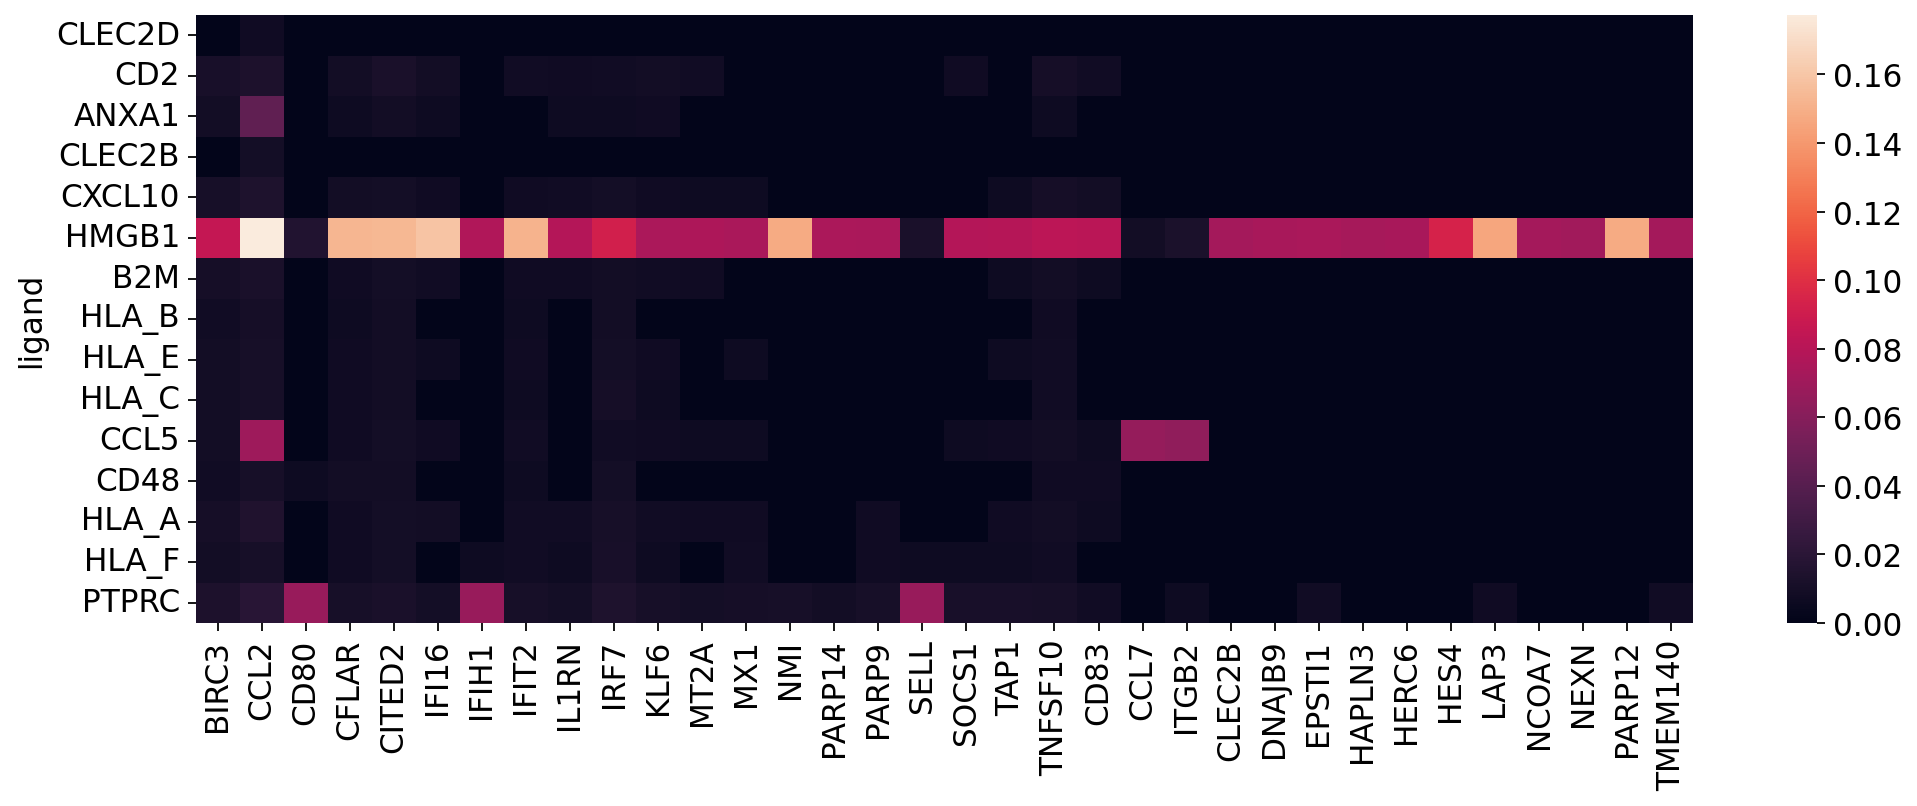

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.heatmap(vis_ligand_target, xticklabels=True, ax=ax)
plt.show()

Perfect, we end up with ligands that are most probable to affect downstream signalling in the receiver cell type(s), as well as their most likely targets.

### Combining NicheNet output with ligand-receptor inference

NicheNet and ligand-receptor methods are not exclusive, but rather complimentary, as they address different questions and in different ways. Basic ligand-receptor methods, such as the ones that we show above, infer ligand-receptor interactions using the expression of interacting ligands and receptors, and typically work on "steady-state" data. On the contrary, NicheNet predicts which of these inferred ligand-receptor links are possibly the most functional based on gene expression changes that are induced in the target cell type(s), in a process largely dependent on prior knowledge alone. Thus, while the choice of tool depends on the research question, one could also see ligand-receptor (e.g. CellPhoneDB or LIANA) methods and intracellular signalling CCC methods (e.g. NicheNet) as complementary.

For example, given the top 5 prioritized ligands, we can focus on ligand-receptor that include those and the receiver cell type(s) that we used to infer the active ligands.

So, let's see which ligand-receptor interactions that involve the top 5 potentially active ligands from NicheNet were prioritized as consistently relevant by the different methods in LIANA:

In [35]:
ligand_oi = ligand_activities.head(5)["test_ligand"].values

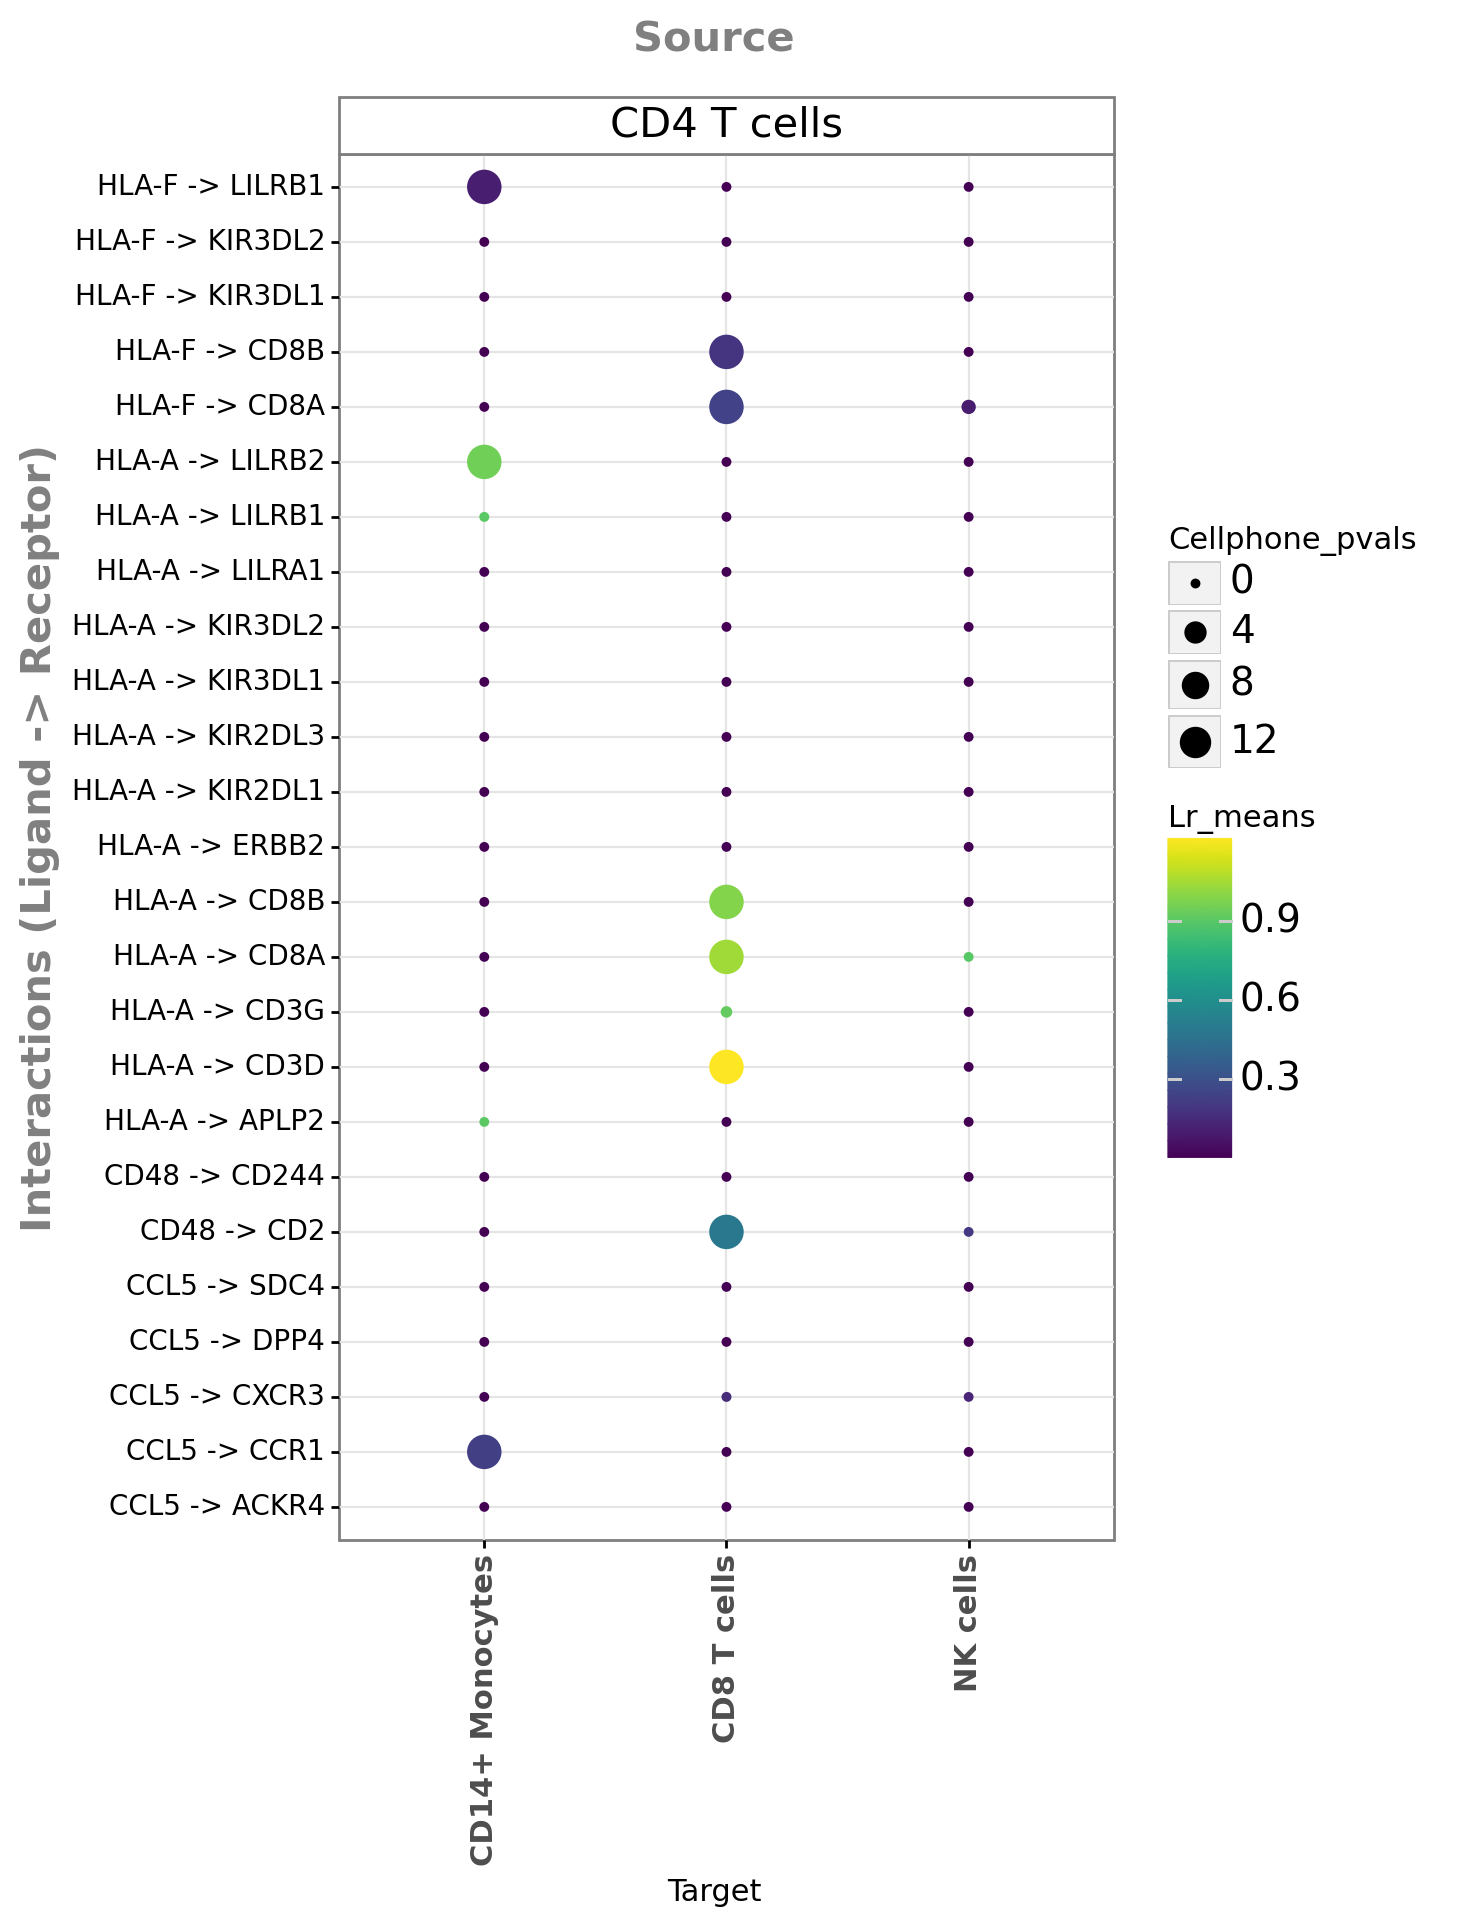

<ggplot: (8789836544829)>

In [36]:
li.pl.dotplot(
    adata=adata_stim,
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=["CD4 T cells"],
    target_labels=["CD8 T cells", "CD14+ Monocytes", "NK cells"],
    # keep only those ligands
    filterby="ligand_complex",
    filter_lambda=lambda x: np.isin(x, ligand_oi),
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    orderby="magnitude_rank",
    orderby_ascending=False,  # we want to prioritize those with highest expression
    top_n=25,  # and we want to keep only the top 25 interactions
    figure_size=(5, 9),
    size_range=(1, 6),
)

So, from the results above we can hypothesize that the ligand activities inferred by NicheNet, are perhaps affecting the cell types via ligand-receptor interactions specific to each cell type pair.
Or in other words, while the same ligands may be active as a consequence of IFN-β stimulation, but they likely induce cell-type specific signal transduction changes.

While we use NicheNet and LIANA in this case, some recent CCC tool developments provide various combinations of the ideas and assumptions in these two categories of CCC inference methods (e.g. CellCall, scSeqComm, Cellinker).

## Key takeaways

#### Assumptions & Limitations

The shared purpose of the methods considered in this work is to predict the most relevant intercellular interactions, between different cell types using single-cell transcriptomics data. Thus, all methods assume that the gene expression of different cell types is an informative proxy of the CCC events that occur within the sampled tissue. While single-cell transcriptomics enables the inference of CCC events at a previously unprecedented scale, some assumptions and limitations should be kept in mind. 
Starting with the assumption protein co-expressions reflect intercellular interactions, and consequently any they are also reflective of any events preceding the interaction, including protein translation and processing, secretion, and diffusion {cite}`armingol_2021,dimitrov_2022` (**Figure 22.2**). Furthermore, if cell communication within an organism is conceptualized as the combination of CCC events that occur at different 'length scales' or ranges {cite}`palla2022spatial`, then the CCC events that can be inferred from single-cell transcriptomics are potentially limited to only the protein-mediated events that occur at 'local' ranges, i.e. between the cell types were sampled. As a result, long-range signalling and CCC driven by other molecules, such as endocrine signalling and system gradients like Calcium and Oxygen concentrations, are likely not captured {cite}`dimitrov_2022`.

In addition, while the grouping of cell types according to their lineage is common practice to structure our data, when considering the tissue as the place where communication takes place, interactions do not necessarily occur between cell types but rather individual cells {cite}`wilk_2022`. Also, the intercellular interactions are typically presented as one-to-one events between cell types and/or proteins. Therefore, the assumption that the potential co-expression events across cell types might not necessarily reflect true signalling, as to fundamentally capture the events within a local community, one must identify the magnitude, directionality and biological relevance of the messages passed between the cells within that community {cite}`armingol_2021`. 

<img src="../_static/images/mechanisms/ccc_limitations.png" alt="CCC Overview" class="bg-primary mb-1" width="800px">

**FIGURE 22.2**. Assumptions and Limitations of Cell-Cell Communication from single-cell transcriptomics data

### Outlook:

As a consequence of the ongoing developments within the single-cell and the cell-cell communication field specifically, there are are already attemps to address some of the limitations of CCC inference, including:
- The inference interactions mediated by metabolites, or small molecules {cite}`zheng_2022,garciaalonso_2022,zhang_2021`
- CCC inference at the single-cell resolution {cite}`raredon_2023,wang_2019,wilk_2022`
- Enabling cross-condition comparisons {cite}`hou2020predicting,raredon_2022,jin_2021,nagai2021crosstalker`, and untargetted factorization approaches to infer cross-sample CCC patterns {cite}`armingol_2022`

## Quiz

- Q1. What are the first three limitations that come to mind when inferring CCC from single-cell transcriptomics data?
- Q2. What is the role of heteromeric complexes in ligand-receptor inference?
- Q3. Can you think of an advantage and a disadvantage of inference based on prior-knowledge?

## Session Info

In [37]:
%%R
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/dbdimitrov/anaconda3/envs/liana4.1/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] nichenetr_1.1.1             forcats_0.5.2              
 [3] stringr_1.5.0               dplyr_1.0.10               
 [5] purrr_1.0.0                 readr_2.1.3                
 [7] tidyr_1.2.1                 tibble_3.1.8               
 [9] ggplot2_3.4.0             

In [38]:
session_info.show()

## References

```{bibliography}
:filter: docname in docnames
```